In [115]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

# Problem 1

In [4]:
# Generating a Poisson background with mean of 100.
background = stats.poisson.rvs(100,size=1000000)

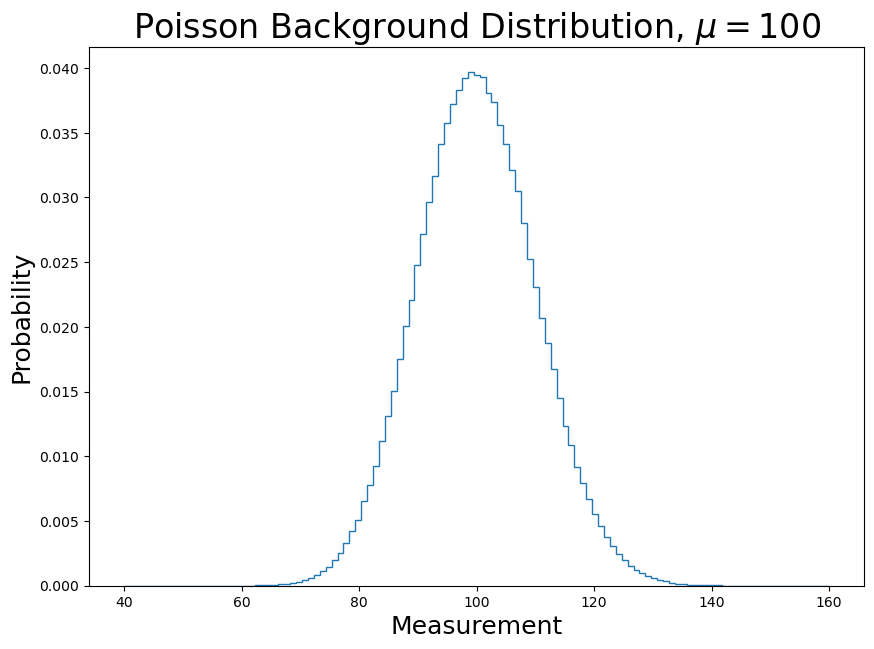

In [119]:
# plotting the background
plt.figure(figsize=(10,7))
plt.title("Poisson Background Distribution, $\mu=100$",fontsize=24)
plt.xlabel('Measurement',fontsize=18)
plt.ylabel('Probability',fontsize=18)

plt.hist(background, histtype='step',density=True,bins=np.linspace(40,160,120))

plt.show()

In the above graph, we see the generated background distribution of a Poisson with a mean of 100. This graph looks remarkably like a normal distribution, and this is due to the fact that a Poisson with a high mean begins to approximate a Gaussian.

In [6]:
# Finds probability of 5 sigma event
prob = stats.norm.cdf(5)

# Finds the inverse of the probility, i.e. the number of events needed for a 5 sigma reading
events = stats.poisson.ppf(prob, mu=100)
print("The 5 sigma threshold for a Poisson Distribution (mu = 100) is {} events.".format(events))

The 5 sigma threshold for a Poisson Distribution (mu = 100) is 154.0 events.


The above code first looks at a 0 centered Gaussian with a standard deviation of 1. It finds the area under the curve between 5 and infinity, or in other words the odds that a measurement would be 5 or higher. This probability is then passed into the percent point function of a Poisson with a mean of 100. The percent point function finds the point along the distribution with the given mean where the integral from that point to infinity is equal to the number passed in. So ```events = stats.poisson.ppf(prob, mu=100)``` is solving for $a$ in the equation $\int_{events}^{a} \frac{100^x}{x!}e^{-100}dx = \int_{5}^{\infty}\frac{1}{2\pi}e^{-\frac{1}{2}x^2}dx$. In this equation, a is 154.

# Problem 2

In [26]:
# Generating a signal
min_signal = stats.poisson.ppf(stats.norm.cdf(8), 100)
max_signal = stats.poisson.ppf(stats.norm.cdf(30), 100)
print("Minimum Signal:\t{}\nMaximum Signal:\t{}".format(min_signal, max_signal))

Minimum Signal:	190.0
Maximum Signal:	inf


We can see from the above that the minimum signal strength for the problem (8 $\sigma$) would be a measurement of 190 events or higher. However, when we look for a maximum value, we see that this is infinity, which is not the case at all. This is due to the limitations of the computer with respect to bit precision. There are not enough bits for the computer to be able to calculate ```stats.norm.cdf(9)``` to the level of precision needed, let alone ```stats.norm.cdf(9)```. However, treating the distribution as a Gaussian, which was discussed above for reference, we can create a rough maximum for a 30 $\sigma$ signal. We know 8 $\sigma$ is at 190 events, while 5 $\sigma$ is at 154 events. Thus, each $\sigma$ equates to roughly 12 events ($\frac{190-154}{8-5} = 12$). So we can expect 30 $\sigma$ to be equal to 360 events. Using the bounds of 190 to 360, I chose to use 192 as my signal strength ($\sigma = 8.2$), as I am anticipating more errors as a result of harware limitations.

## A)

In [77]:
signal_mean = 192
signal = stats.poisson.rvs(192,size=200000)

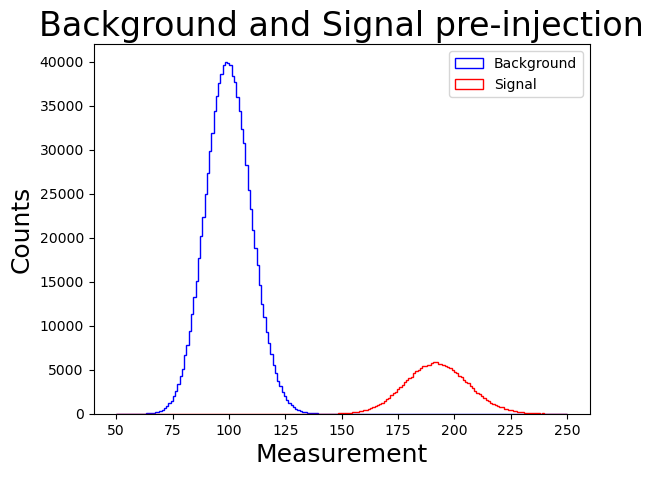

In [130]:
plt.hist([signal, background], bins = np.linspace(50,250,200), histtype = 'step', color=['r', 'b'], label=['Signal', 'Background'])
plt.title('Background and Signal pre-injection', fontsize = 24)
plt.xlabel('Measurement', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)
plt.legend()
plt.show()

Here we can see the distributions of the two signals. In blue we see the background signal, while in red, we have our generated signal. The generated signal is of the form of a Poisson since this is a problem involving counting particles, which is naturally modeled by a Poisson for lower values. We can see that the signal plotted is as expected, a Poisson with a mean of 192. 

In [106]:
# Shaping signal to add to background
shaped_signal = np.append(signal, np.zeros(len(background) - len(signal)))
post_inject = background + shaped_signal

## A)

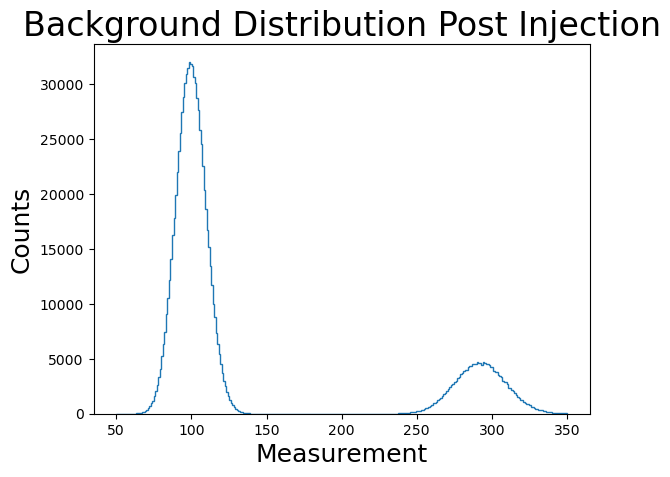

In [131]:
plt.hist(post_inject, bins = np.linspace(50,350,300), histtype = "step")
plt.title("Background Distribution Post Injection",fontsize=24)
plt.xlabel('Measurement',fontsize=18)
plt.ylabel('Counts',fontsize=18)
plt.show()

Here we see what the background looks like after the generated siganl is injected. The crucial feature to note is that our signal is now centered around a mean of 292 instead of 192. This is because the mean of the background pdf is 100, which is added to the mean of the signal distribution when they are combined together. However, we do not see the same behaviour out of the background distribution; instead it stays centered around 100. The reason we see one shift while the other stays stationary, is due to how the signal was added in. The signal array was made to be the exact same shape as the background distribution, with the excess spaced filled in with zeros. The parts of the array that were zero added to create the left peak, while the right peak was from the non-zero values. These were added to the non-zero background distribution, which in turn shifted the mean by a non-zero amount. Another, less noticable feature is that the peak of the background distribution is now lower. This is because some of the measurements from the background distribution were manipulated to the signal distribution when we added the signal while the total number of events remained the same. 

## B)

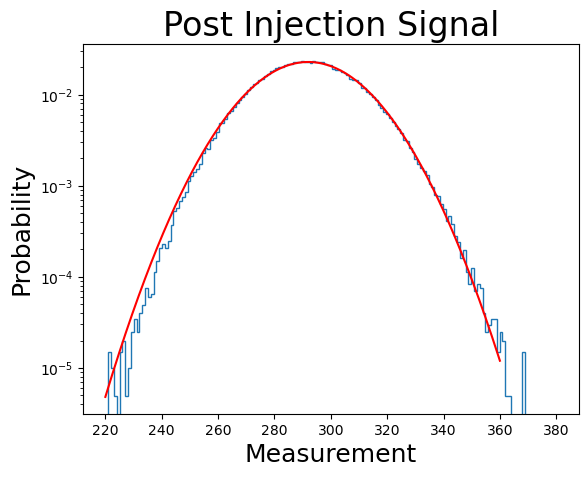

In [151]:
plt.hist(post_inject, bins = np.linspace(220,380,160), density = True, histtype = "step")
plt.title("Post Injection Signal",fontsize=24)
plt.xlabel('Measurement',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.semilogy()
x = np.linspace(220,360,10000)
plt.plot(x,scipy.stats.norm.pdf(x, loc = 292, scale = 17.5),color = 'red')
plt.show()

Above we have plotted a semilog plot of the post injection signal, with a Gaussian curve overlayed. From this we can see that the new background post injection is very symmetric, given how well it fits a Gaussian curve, which itself is symmetric. However, there still is a bias in the observed signal that we must content with. This originates from the fact that the observed signal is not equal in probability to be above or below the mean than the true injected signal. In this example, the range for our inected signal is decenlty small, an the background is only capable of adding positive values to the signal. Because of this, it is impossible for the observed signal resulting from this background to be below what the true value is. Given the nature of the signal that we injected, we can expect a bias like this since it was based on a Poisson distribution about a mean that we selectedd, as opposed to to uniform and random signals across a wide range.

# Problem 3

## A)

Rather than injecting one single Poisson distribution about one mean, now, we are looking to generate a large amount of random signals within the bounds of a predefine range. We can chose our range to be between 0, and stopping several sigmas above 154 events, which was the background's 5 $\sigma$ threshold. For this problem, I chose to stop at 420 events, thus granting us a range of 0 to 420. We need to guarantee that the random values we generate are uniformly distributed so that we can avoid an implicit prior as well as have equal probabilities at either end of the signal range for strength.

In [152]:
# Uniform signal
uniform_injection = np.random.uniform(low=0,high=400,size=1000000)
# Adding uniform signal to background
data = background + uniform_injection